=== 港口调度优化模型 - 完整版 ===

样例数据生成完成:
船舶数量: 20
泊位数量: 10
拖船数量: 10
时间范围: 48

=== 马力分布信息 ===
拖船马力:
  拖船0: 1383马力 (小型)
  拖船1: 1392马力 (小型)
  拖船2: 2581马力 (大型)
  拖船3: 2667马力 (大型)
  拖船4: 2173马力 (中型)
  拖船5: 3657马力 (大型)
  拖船6: 3147马力 (大型)
  拖船7: 1709马力 (中型)
  拖船8: 3966马力 (大型)
  拖船9: 1744马力 (中型)

船舶马力需求:
  船舶0: 3010马力 (大型) 
  船舶1: 1887马力 (中型) 
  船舶2: 3136马力 (大型) 
  船舶3: 2348马力 (大型) 
  船舶4: 1069马力 (小型) 
  船舶5: 675马力 (小型) 
  船舶6: 1718马力 (中型) 
  船舶7: 2471马力 (大型) 
  船舶8: 2340马力 (大型) 
  船舶9: 1578马力 (中型) 
  船舶10: 2523马力 (大型) 
  船舶11: 5725马力 (超大型) 需要多艘拖船
  船舶12: 3452马力 (大型) 
  船舶13: 1167马力 (小型) 
  船舶14: 2412马力 (大型) 
  船舶15: 1470马力 (中型) 
  船舶16: 709马力 (小型) 
  船舶17: 1478马力 (中型) 
  船舶18: 3438马力 (大型) 
  船舶19: 1934马力 (中型) 

预计需要多艘拖船的船舶: [11]

构建数学模型...
添加约束条件...
设置目标函数...
开始求解...
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Set parameter OutputFlag to value 1
Set parameter Threads to value 4
Set parameter Heuristics to value 0.2
Set parameter MIPFocus to value 1
Gurobi Optimizer versio

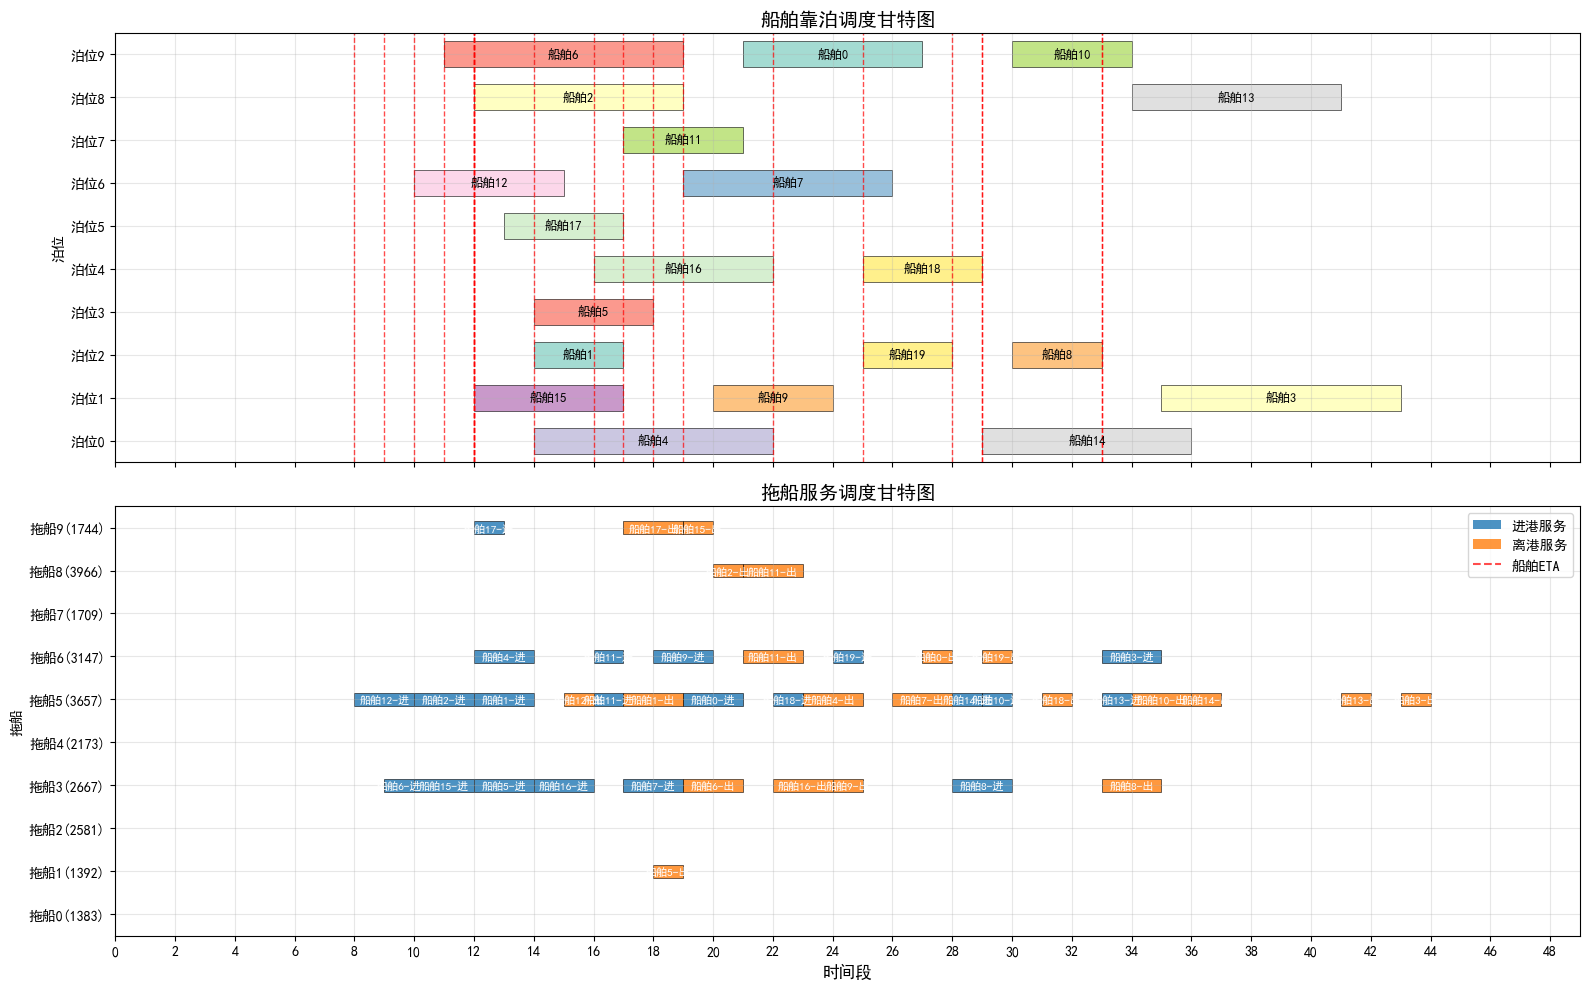


=== 调度统计 ===
总船舶数量: 20
已调度船舶: 20
未调度船舶: 0
调度成功率: 100.0%

泊位利用率:
  泊位0: 31.2% (15/48时段)
  泊位1: 35.4% (17/48时段)
  泊位2: 18.8% (9/48时段)
  泊位3: 8.3% (4/48时段)
  泊位4: 20.8% (10/48时段)
  泊位5: 8.3% (4/48时段)
  泊位6: 25.0% (12/48时段)
  泊位7: 8.3% (4/48时段)
  泊位8: 29.2% (14/48时段)
  泊位9: 37.5% (18/48时段)

拖船利用率:
  拖船0: 0.0% (0/48时段)
  拖船1: 2.1% (1/48时段)
  拖船2: 0.0% (0/48时段)
  拖船3: 37.5% (18/48时段)
  拖船4: 0.0% (0/48时段)
  拖船5: 54.2% (26/48时段)
  拖船6: 25.0% (12/48时段)
  拖船7: 0.0% (0/48时段)
  拖船8: 6.2% (3/48时段)
  拖船9: 8.3% (4/48时段)

拖船协作分析:
  船舶11进港: 2艘拖船协作 (需求5725马力，提供6804马力)
  船舶11离港: 2艘拖船协作 (需求5725马力，提供7113马力)
  单拖船服务: 38次 (95.0%)
  多拖船协作: 2次 (5.0%)

ETA偏差统计:
  准时到达: 17艘 (85.0%)
  提前到达: 3艘 (15.0%)
  延迟到达: 0艘 (0.0%)
pandas未安装，跳过Excel导出


In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random
from typing import Dict, List, Set, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class PortSchedulingModel:
    def __init__(self):
        """初始化港口调度模型"""
        self.model = None
        self.variables = {}
        self.parameters = {}
        
    def generate_sample_data(self, num_ships=10, num_berths=5, num_tugs=8, time_horizon=48):
        """生成示例数据"""
        random.seed(42)  # 设置随机种子以便结果可重现
        
        # 基础集合
        self.I = list(range(num_ships))  # 船舶集合
        self.J = list(range(num_berths))  # 泊位集合
        self.K = list(range(num_tugs))  # 拖船集合
        self.T = list(range(1, time_horizon + 1))  # 时间集合
        
        # 船舶-泊位兼容性
        self.J_i = {}  # 船舶i可停泊的泊位集合
        self.I_j = {j: [] for j in self.J}  # 泊位j可接纳的船舶集合
        
        for i in self.I:
            # 每艘船可以停靠2-4个泊位
            num_compatible = random.randint(2, min(4, len(self.J)))
            self.J_i[i] = random.sample(self.J, num_compatible)
            for j in self.J_i[i]:
                self.I_j[j].append(i)
        
        # 时间相关参数
        self.ETA = {}  # 预期到达时段
        self.D = {}    # 靠泊作业时长
        self.tau_in = {}   # 进港拖船服务时长
        self.tau_out = {}  # 离港拖船服务时长
        self.Delta_early = {}  # 允许的最大提前时段数
        self.Delta_late = {}   # 允许的最大延迟时段数
        
        for i in self.I:
            self.ETA[i] = random.randint(5, time_horizon - 15)
            self.D[i] = random.randint(3, 8)  # 作业时长3-8时段
            self.tau_in[i] = random.randint(1, 2)   # 进港服务时长
            self.tau_out[i] = random.randint(1, 2)  # 离港服务时长
            self.Delta_early[i] = random.randint(2, 5)  # 允许提前时段
            self.Delta_late[i] = random.randint(3, 8)   # 允许延迟时段
        
        # 成本相关参数
        self.alpha = {i: random.uniform(0.5, 2.0) for i in self.I}  # 优先级权重
        self.beta = {i: random.uniform(10, 50) for i in self.I}     # 单位等待成本
        self.gamma = {i: random.uniform(20, 100) for i in self.I}   # JIT偏差单位成本
        self.c = {k: random.uniform(50, 150) for k in self.K}       # 拖船单位时段使用成本
        
        # 马力相关参数 - 修改为更真实的设置
        # 拖船马力分布：小型、中型、大型拖船
        self.P = {}
        for k in self.K:
            tug_type = random.choice(['small', 'medium', 'large'])
            if tug_type == 'small':
                self.P[k] = random.randint(800, 1500)    # 小型拖船
            elif tug_type == 'medium':
                self.P[k] = random.randint(1500, 2500)   # 中型拖船
            else:
                self.P[k] = random.randint(2500, 4000)   # 大型拖船
        
        # 船舶马力需求：根据船舶大小设置，部分大船需要多艘拖船
        self.P_req = {}
        for i in self.I:
            ship_type = random.choice(['small', 'medium', 'large', 'very_large'])
            if ship_type == 'small':
                self.P_req[i] = random.randint(600, 1200)    # 小船
            elif ship_type == 'medium':
                self.P_req[i] = random.randint(1200, 2200)   # 中型船
            elif ship_type == 'large':
                self.P_req[i] = random.randint(2200, 3500)   # 大型船
            else:
                self.P_req[i] = random.randint(3500, 6000)   # 超大型船，需要多艘拖船
        
        # 系统参数
        self.H_max = 4      # 单次服务允许的最大拖船数量
        self.epsilon_time = 2  # 时序约束允许的最大时间偏差
        self.M = 10000      # 大数参数
        
        # 目标函数权重系数
        self.lambda1 = 1.0  # 未服务惩罚权重
        self.lambda2 = 1.0  # 在港总时间成本权重
        self.lambda3 = 1.0  # ETA偏差成本权重
        self.lambda4 = 1.0  # 拖船使用成本权重
        
        print("样例数据生成完成:")
        print(f"船舶数量: {len(self.I)}")
        print(f"泊位数量: {len(self.J)}")
        print(f"拖船数量: {len(self.K)}")
        print(f"时间范围: {len(self.T)}")
        
        # 显示马力分布信息
        print("\n=== 马力分布信息 ===")
        print("拖船马力:")
        for k in self.K:
            tug_type = "小型" if self.P[k] <= 1500 else "中型" if self.P[k] <= 2500 else "大型"
            print(f"  拖船{k}: {self.P[k]}马力 ({tug_type})")
        
        print("\n船舶马力需求:")
        multi_tug_ships = []
        max_single_tug_power = max(self.P.values())
        for i in self.I:
            ship_type = ("小型" if self.P_req[i] <= 1200 else 
                        "中型" if self.P_req[i] <= 2200 else 
                        "大型" if self.P_req[i] <= 3500 else "超大型")
            need_multi = "需要多艘拖船" if self.P_req[i] > max_single_tug_power else ""
            if self.P_req[i] > max_single_tug_power:
                multi_tug_ships.append(i)
            print(f"  船舶{i}: {self.P_req[i]}马力 ({ship_type}) {need_multi}")
        
        if multi_tug_ships:
            print(f"\n预计需要多艘拖船的船舶: {multi_tug_ships}")
        
    def build_model(self):
        """构建Gurobi模型"""
        self.model = gp.Model("PortScheduling")
        
        # 决策变量
        # x[i,j,t]: 船舶i在时段t开始在泊位j靠泊
        self.x = {}
        for i in self.I:
            for j in self.J_i[i]:
                for t in self.T:
                    # 检查时间窗口约束
                    if t + self.D[i] - 1 <= max(self.T):
                        self.x[i,j,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                         name=f"x_{i}_{j}_{t}")
        
        # y_in[i,k,t]: 拖船k在时段t启动船舶i的进港服务
        self.y_in = {}
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    # 应用拖船服务边界约束
                    if (t >= self.ETA[i] - self.Delta_early[i] and 
                        t <= self.ETA[i] + self.Delta_late[i]):
                        self.y_in[i,k,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                             name=f"y_in_{i}_{k}_{t}")
        
        # y_out[i,k,t]: 拖船k在时段t启动船舶i的离港服务
        self.y_out = {}
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    self.y_out[i,k,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                          name=f"y_out_{i}_{k}_{t}")
        
        # z_in[i,t]: 船舶i在时段t开始进港拖船服务（辅助变量）
        self.z_in = {}
        for i in self.I:
            for t in self.T:
                if (t >= self.ETA[i] - self.Delta_early[i] and 
                    t <= self.ETA[i] + self.Delta_late[i]):
                    self.z_in[i,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                       name=f"z_in_{i}_{t}")
        
        # z_out[i,t]: 船舶i在时段t开始离港拖船服务（辅助变量）
        self.z_out = {}
        for i in self.I:
            for t in self.T:
                self.z_out[i,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                    name=f"z_out_{i}_{t}")
        
        # u_early[i]: 船舶i相对于ETA的提前时间
        self.u_early = {}
        for i in self.I:
            self.u_early[i] = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0,
                                               name=f"u_early_{i}")
        
        # u_late[i]: 船舶i相对于ETA的延迟时间
        self.u_late = {}
        for i in self.I:
            self.u_late[i] = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0,
                                              name=f"u_late_{i}")
        
        self.model.update()
        
    def add_constraints(self):
        """添加约束条件"""
        
        # 约束(1): 每艘船最多分配一次
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T) <= 1,
                name=f"ship_assign_{i}"
            )
        
        # 约束(2): 进港拖船与泊位耦合
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.z_in.get((i,t), 0) for t in self.T) == 
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T),
                name=f"tug_berth_in_{i}"
            )
        
        # 约束(3): 离港拖船与泊位耦合
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.z_out.get((i,t), 0) for t in self.T) == 
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T),
                name=f"tug_berth_out_{i}"
            )
        
        # 约束(4): 拖船马力约束
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        gp.quicksum(self.P[k] * self.y_in.get((i,k,t), 0) for k in self.K) >= 
                        self.P_req[i] * self.z_in[i,t],
                        name=f"power_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        gp.quicksum(self.P[k] * self.y_out.get((i,k,t), 0) for k in self.K) >= 
                        self.P_req[i] * self.z_out[i,t],
                        name=f"power_out_{i}_{t}"
                    )
        
        # 约束(6): 拖船数量限制
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        gp.quicksum(self.y_in.get((i,k,t), 0) for k in self.K) <= 
                        self.H_max * self.z_in[i,t],
                        name=f"tug_limit_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        gp.quicksum(self.y_out.get((i,k,t), 0) for k in self.K) <= 
                        self.H_max * self.z_out[i,t],
                        name=f"tug_limit_out_{i}_{t}"
                    )
        
        # 约束(8): 辅助变量定义
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        self.z_in[i,t] <= gp.quicksum(self.y_in.get((i,k,t), 0) for k in self.K),
                        name=f"aux_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        self.z_out[i,t] <= gp.quicksum(self.y_out.get((i,k,t), 0) for k in self.K),
                        name=f"aux_out_{i}_{t}"
                    )
        
        # 约束(10): 泊位容量约束
        for j in self.J:
            for t in self.T:
                berth_usage = []
                for i in self.I_j[j]:
                    for tau in range(max(1, t - self.D[i] + 1), t + 1):
                        if (i,j,tau) in self.x:
                            berth_usage.append(self.x[i,j,tau])
                
                if berth_usage:
                    self.model.addConstr(
                        gp.quicksum(berth_usage) <= 1,
                        name=f"berth_capacity_{j}_{t}"
                    )
        
        # 约束(11): 拖船容量约束
        for k in self.K:
            for t in self.T:
                tug_usage = []
                
                # 进港服务占用
                for i in self.I:
                    for tau in range(max(1, t - self.tau_in[i] + 1), t + 1):
                        if (i,k,tau) in self.y_in:
                            tug_usage.append(self.y_in[i,k,tau])
                
                # 出港服务占用
                for i in self.I:
                    for tau in range(max(1, t - self.tau_out[i] + 1), t + 1):
                        if (i,k,tau) in self.y_out:
                            tug_usage.append(self.y_out[i,k,tau])
                
                if tug_usage:
                    self.model.addConstr(
                        gp.quicksum(tug_usage) <= 1,
                        name=f"tug_capacity_{k}_{t}"
                    )
        
        # 约束(13): 进港时序约束
        for i in self.I:
            assigned = gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
            
            if assigned.size() > 0:  # 只有当船舶可能被分配时才添加约束
                berth_start = gp.quicksum(t * self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
                tug_end = gp.quicksum((t + self.tau_in[i]) * self.z_in.get((i,t), 0) for t in self.T)
                
                self.model.addConstr(
                    berth_start - tug_end >= 0,
                    name=f"timing_in_lower_{i}"
                )
                self.model.addConstr(
                    berth_start - tug_end <= self.epsilon_time * assigned,
                    name=f"timing_in_upper_{i}"
                )
        
        # 约束(14): 离港时序约束
        for i in self.I:
            assigned = gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
            
            if assigned.size() > 0:  # 只有当船舶可能被分配时才添加约束
                tug_start = gp.quicksum(t * self.z_out.get((i,t), 0) for t in self.T)
                berth_end = gp.quicksum((t + self.D[i]) * self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
                
                self.model.addConstr(
                    tug_start - berth_end >= 0,
                    name=f"timing_out_lower_{i}"
                )
                self.model.addConstr(
                    tug_start - berth_end <= self.epsilon_time * assigned,
                    name=f"timing_out_upper_{i}"
                )
        
        # 约束(15): ETA偏差线性化约束
        for i in self.I:
            tug_start_time = gp.quicksum(t * self.z_in.get((i,t), 0) for t in self.T)
            
            self.model.addConstr(
                tug_start_time == self.ETA[i] + self.u_late[i] - self.u_early[i],
                name=f"eta_deviation_{i}"
            )
        
    def set_objective(self):
        """设置目标函数"""
        
        # Z1: 未服务惩罚
        Z1 = gp.quicksum(
            self.M * self.alpha[i] * (1 - gp.quicksum(self.x.get((i,j,t), 0) 
                                                      for j in self.J_i[i] for t in self.T))
            for i in self.I
        )
        
        # Z2: 在港总时间成本
        Z2 = gp.quicksum(
            self.alpha[i] * self.beta[i] * (
                gp.quicksum((t + self.tau_out[i]) * self.z_out.get((i,t), 0) for t in self.T) -
                gp.quicksum(t * self.z_in.get((i,t), 0) for t in self.T)
            )
            for i in self.I
        )
        
        # Z3: ETA偏差成本
        Z3 = gp.quicksum(
            self.alpha[i] * self.gamma[i] * (self.u_early[i] + self.u_late[i])
            for i in self.I
        )
        
        # Z4: 拖船使用成本
        Z4 = gp.quicksum(
            self.c[k] * (
                gp.quicksum(self.tau_in[i] * self.y_in.get((i,k,t), 0) 
                           for i in self.I for t in self.T) +
                gp.quicksum(self.tau_out[i] * self.y_out.get((i,k,t), 0) 
                           for i in self.I for t in self.T)
            )
            for k in self.K
        )
        
        # 总目标函数
        objective = (self.lambda1 * Z1 + self.lambda2 * Z2 + 
                    self.lambda3 * Z3 + self.lambda4 * Z4)
        self.model.setObjective(objective, GRB.MINIMIZE)
        
    def solve(self):
        """求解模型"""
        
        # 设置求解参数
        self.model.Params.TimeLimit = 600  # 10分钟时间限制
        self.model.Params.MIPGap = 0.05    # 5% gap
        self.model.Params.OutputFlag = 1   # 显示求解过程
        self.model.Params.Threads = 4      # 使用4个线程
        
        # 设置启发式参数
        self.model.Params.Heuristics = 0.2  # 20%时间用于启发式
        self.model.Params.MIPFocus = 1       # 专注于找到可行解
        
        # 求解
        self.model.optimize()
        
        # 输出结果
        if self.model.Status == GRB.OPTIMAL:
            print("\n=== 求解成功 ===")
            print(f"最优目标值: {self.model.ObjVal:.2f}")
            self.print_solution()
            self.analyze_solution()
        elif self.model.Status == GRB.TIME_LIMIT:
            print(f"\n=== 时间限制内找到可行解 ===")
            if hasattr(self.model, 'ObjVal'):
                print(f"当前最优目标值: {self.model.ObjVal:.2f}")
                print(f"Gap: {self.model.MIPGap*100:.2f}%")
                self.print_solution()
                self.analyze_solution()
        else:
            print(f"\n求解状态: {self.model.Status}")
            if self.model.Status == GRB.INFEASIBLE:
                print("模型不可行")
                self.model.computeIIS()
                self.model.write("infeasible.ilp")
                print("不可行系统已写入 infeasible.ilp")
            elif self.model.Status == GRB.UNBOUNDED:
                print("模型无界")
                
    def print_solution(self):
        """打印解决方案"""
        print("\n=== 船舶调度方案 ===")
        
        scheduled_ships = []
        unscheduled_ships = []
        
        for i in self.I:
            assigned = False
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        # 找到对应的进港和离港拖船服务
                        in_time = None
                        out_time = None
                        in_tugs = []
                        out_tugs = []
                        
                        for t_tug in self.T:
                            if (i,t_tug) in self.z_in and self.z_in[i,t_tug].X > 0.5:
                                in_time = t_tug
                                for k in self.K:
                                    if (i,k,t_tug) in self.y_in and self.y_in[i,k,t_tug].X > 0.5:
                                        in_tugs.append(k)
                            
                            if (i,t_tug) in self.z_out and self.z_out[i,t_tug].X > 0.5:
                                out_time = t_tug
                                for k in self.K:
                                    if (i,k,t_tug) in self.y_out and self.y_out[i,k,t_tug].X > 0.5:
                                        out_tugs.append(k)
                        
                        eta_deviation = ""
                        if self.u_early[i].X > 0.01:
                            eta_deviation = f"(提前{self.u_early[i].X:.1f}时段)"
                        elif self.u_late[i].X > 0.01:
                            eta_deviation = f"(延迟{self.u_late[i].X:.1f}时段)"
                        
                        # 计算拖船总马力
                        in_total_power = sum(self.P[k] for k in in_tugs)
                        out_total_power = sum(self.P[k] for k in out_tugs)
                        
                        print(f"船舶 {i}: 泊位 {j}, 靠泊时段 {t}-{t+self.D[i]-1} (ETA: {self.ETA[i]}) {eta_deviation}")
                        print(f"         需求马力: {self.P_req[i]}")
                        print(f"         进港: 时段{in_time}, 拖船{in_tugs} (总马力: {in_total_power})")
                        print(f"         出港: 时段{out_time}, 拖船{out_tugs} (总马力: {out_total_power})")
                        
                        scheduled_ships.append(i)
                        assigned = True
                        break
                if assigned:
                    break
            
            if not assigned:
                unscheduled_ships.append(i)
        
        if unscheduled_ships:
            print(f"\n未分配船舶: {unscheduled_ships}")
        
        print(f"\n调度统计:")
        print(f"已调度船舶: {len(scheduled_ships)}/{len(self.I)}")
        print(f"调度率: {len(scheduled_ships)/len(self.I)*100:.1f}%")
        
    def analyze_solution(self):
        """分析解决方案"""
        if not hasattr(self.model, 'ObjVal'):
            return
            
        print("\n=== 目标函数分析 ===")
        
        # 计算各个目标函数分量
        Z1_val = 0  # 未服务惩罚
        Z2_val = 0  # 在港总时间成本
        Z3_val = 0  # ETA偏差成本
        Z4_val = 0  # 拖船使用成本
        
        for i in self.I:
            assigned = sum(self.x.get((i,j,t), 0).X if (i,j,t) in self.x else 0 
                          for j in self.J_i[i] for t in self.T)
            
            if assigned < 0.5:  # 未分配
                Z1_val += self.M * self.alpha[i]
            else:
                # 在港时间成本
                in_time = sum(t * (self.z_in.get((i,t), 0).X if (i,t) in self.z_in else 0) 
                             for t in self.T)
                out_time = sum((t + self.tau_out[i]) * (self.z_out.get((i,t), 0).X if (i,t) in self.z_out else 0) 
                              for t in self.T)
                Z2_val += self.alpha[i] * self.beta[i] * (out_time - in_time)
                
                # ETA偏差成本
                Z3_val += self.alpha[i] * self.gamma[i] * (self.u_early[i].X + self.u_late[i].X)
        
        # 拖船使用成本
        for k in self.K:
            for i in self.I:
                for t in self.T:
                    if (i,k,t) in self.y_in:
                        Z4_val += self.c[k] * self.tau_in[i] * self.y_in[i,k,t].X
                    if (i,k,t) in self.y_out:
                        Z4_val += self.c[k] * self.tau_out[i] * self.y_out[i,k,t].X
        
        print(f"Z1 (未服务惩罚): {Z1_val:.2f}")
        print(f"Z2 (在港时间成本): {Z2_val:.2f}")
        print(f"Z3 (ETA偏差成本): {Z3_val:.2f}")
        print(f"Z4 (拖船使用成本): {Z4_val:.2f}")
        print(f"总成本: {Z1_val + Z2_val + Z3_val + Z4_val:.2f}")
        
        # 分析拖船使用情况
        print("\n=== 拖船使用分析 ===")
        single_tug_count = 0
        multi_tug_count = 0
        
        for i in self.I:
            assigned = sum(self.x.get((i,j,t), 0).X if (i,j,t) in self.x else 0 
                          for j in self.J_i[i] for t in self.T)
            
            if assigned > 0.5:  # 已分配的船舶
                # 检查进港服务的拖船数量
                for t in self.T:
                    if (i,t) in self.z_in and self.z_in[i,t].X > 0.5:
                        in_tug_count = sum(1 for k in self.K 
                                         if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5)
                        if in_tug_count == 1:
                            single_tug_count += 1
                        elif in_tug_count > 1:
                            multi_tug_count += 1
                            print(f"  船舶{i}进港: 使用{in_tug_count}艘拖船 (需求{self.P_req[i]}马力)")
                        break
        
        total_services = single_tug_count + multi_tug_count
        if total_services > 0:
            print(f"\n单拖船服务: {single_tug_count}次 ({single_tug_count/total_services*100:.1f}%)")
            print(f"多拖船服务: {multi_tug_count}次 ({multi_tug_count/total_services*100:.1f}%)")

    def export_results_to_excel(self, filename="port_schedule_results.xlsx"):
        """将结果导出到Excel文件"""
        if not hasattr(self.model, 'ObjVal'):
            print("没有求解结果可以导出")
            return
        
        # 船舶调度结果
        schedule_data = []
        for i in self.I:
            row = {
                '船舶ID': i,
                'ETA': self.ETA[i],
                '作业时长': self.D[i],
                '分配泊位': None,
                '靠泊开始时段': None,
                '靠泊结束时段': None,
                '进港拖船服务时段': None,
                '进港拖船': None,
                '出港拖船服务时段': None,
                '出港拖船': None,
                'ETA提前时段': self.u_early[i].X,
                'ETA延迟时段': self.u_late[i].X
            }
            
            # 查找分配结果
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        row['分配泊位'] = j
                        row['靠泊开始时段'] = t
                        row['靠泊结束时段'] = t + self.D[i] - 1
                        break
                if row['分配泊位'] is not None:
                    break
            
            # 查找拖船服务
            for t in self.T:
                if (i,t) in self.z_in and self.z_in[i,t].X > 0.5:
                    row['进港拖船服务时段'] = t
                    tugs = [k for k in self.K if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5]
                    row['进港拖船'] = ','.join(map(str, tugs))
                
                if (i,t) in self.z_out and self.z_out[i,t].X > 0.5:
                    row['出港拖船服务时段'] = t
                    tugs = [k for k in self.K if (i,k,t) in self.y_out and self.y_out[i,k,t].X > 0.5]
                    row['出港拖船'] = ','.join(map(str, tugs))
            
            schedule_data.append(row)
        
        # 创建DataFrame并保存
        df = pd.DataFrame(schedule_data)
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name='船舶调度结果', index=False)
            
        print(f"\n结果已导出到 {filename}")

    def extract_solution(self):
        """提取求解结果"""
        if not hasattr(self.model, 'ObjVal'):
            return None
        
        solution = {
            "assigned": [],    # 分配的船舶 (i, j, t)
            "unassigned": [],  # 未分配的船舶
            "inbound": [],     # 进港拖船服务 (i, k, t)  
            "outbound": []     # 离港拖船服务 (i, k, t)
        }
        
        # 收集分配的船舶
        for i in self.I:
            assigned = False
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        solution["assigned"].append((i, j, t))
                        assigned = True
                        break
                if assigned:
                    break
            
            if not assigned:
                solution["unassigned"].append(i)
        
        # 收集拖船服务
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5:
                        solution["inbound"].append((i, k, t))
                    if (i,k,t) in self.y_out and self.y_out[i,k,t].X > 0.5:
                        solution["outbound"].append((i, k, t))
        
        return solution
    
    def prepare_data_for_visualization(self):
        """准备可视化数据"""
        data = {
            "D": self.D,           # 作业时长
            "Tin": self.tau_in,    # 进港拖船服务时长
            "Tout": self.tau_out,  # 离港拖船服务时长
            "ETA": self.ETA,       # 预期到达时间
            "P": self.P,           # 拖船马力
            "P_req": self.P_req    # 船舶马力需求
        }
        
        meta = {
            "num_ships": len(self.I),
            "num_berths": len(self.J),
            "num_tugs": len(self.K),
            "time_horizon": len(self.T)
        }
        
        return data, meta
    
    def print_scheduling_statistics(self, solution, data):
        """打印调度统计信息"""
        print("\n=== 调度统计 ===")
        
        total_ships = len(self.I)
        assigned_ships = len(solution["assigned"])
        unassigned_ships = len(solution["unassigned"])
        
        print(f"总船舶数量: {total_ships}")
        print(f"已调度船舶: {assigned_ships}")
        print(f"未调度船舶: {unassigned_ships}")
        print(f"调度成功率: {assigned_ships/total_ships*100:.1f}%")
        
        # 泊位利用率
        berth_usage = {j: 0 for j in self.J}
        for (i, j, t) in solution["assigned"]:
            berth_usage[j] += data["D"][i]
        
        print(f"\n泊位利用率:")
        total_time = len(self.T)
        for j in self.J:
            utilization = berth_usage[j] / total_time * 100
            print(f"  泊位{j}: {utilization:.1f}% ({berth_usage[j]}/{total_time}时段)")
        
        # 拖船利用率
        tug_usage = {k: 0 for k in self.K}
        for (i, k, t) in solution["inbound"]:
            tug_usage[k] += data["Tin"][i]
        for (i, k, t) in solution["outbound"]:
            tug_usage[k] += data["Tout"][i]
        
        print(f"\n拖船利用率:")
        for k in self.K:
            utilization = tug_usage[k] / total_time * 100
            print(f"  拖船{k}: {utilization:.1f}% ({tug_usage[k]}/{total_time}时段)")
        
        # 拖船协作分析
        print(f"\n拖船协作分析:")
        multi_tug_services = 0
        single_tug_services = 0
        
        # 按船舶统计拖船使用情况
        ship_tug_usage = {}
        for (i, k, t) in solution["inbound"]:
            if i not in ship_tug_usage:
                ship_tug_usage[i] = {"in": [], "out": []}
            ship_tug_usage[i]["in"].append(k)
        
        for (i, k, t) in solution["outbound"]:
            if i not in ship_tug_usage:
                ship_tug_usage[i] = {"in": [], "out": []}
            ship_tug_usage[i]["out"].append(k)
        
        for i, services in ship_tug_usage.items():
            in_count = len(services["in"])
            out_count = len(services["out"])
            
            if in_count > 1:
                multi_tug_services += 1
                in_power = sum(data["P"][k] for k in services["in"])
                print(f"  船舶{i}进港: {in_count}艘拖船协作 (需求{data['P_req'][i]}马力，提供{in_power}马力)")
            else:
                single_tug_services += 1
                
            if out_count > 1:
                multi_tug_services += 1
                out_power = sum(data["P"][k] for k in services["out"])
                print(f"  船舶{i}离港: {out_count}艘拖船协作 (需求{data['P_req'][i]}马力，提供{out_power}马力)")
            else:
                single_tug_services += 1
        
        total_services = multi_tug_services + single_tug_services
        if total_services > 0:
            print(f"  单拖船服务: {single_tug_services}次 ({single_tug_services/total_services*100:.1f}%)")
            print(f"  多拖船协作: {multi_tug_services}次 ({multi_tug_services/total_services*100:.1f}%)")

        # ETA偏差统计
        if assigned_ships > 0:
            early_count = sum(1 for i in self.I if self.u_early[i].X > 0.01)
            late_count = sum(1 for i in self.I if self.u_late[i].X > 0.01)
            ontime_count = assigned_ships - early_count - late_count
            
            print(f"\nETA偏差统计:")
            print(f"  准时到达: {ontime_count}艘 ({ontime_count/assigned_ships*100:.1f}%)")
            print(f"  提前到达: {early_count}艘 ({early_count/assigned_ships*100:.1f}%)")
            print(f"  延迟到达: {late_count}艘 ({late_count/assigned_ships*100:.1f}%)")

    def visualize_solution(self):
        """绘制甘特图"""
        solution = self.extract_solution()
        if solution is None:
            print("无可视化的解决方案")
            return
            
        data, meta = self.prepare_data_for_visualization()
        
        # ---- 文本表格 ----
        print("\n调度结果总览")
        print("-" * 80)
        print(f"{'船舶':<4}{'泊位':<4}{'开始':<6}{'完工':<6}{'需求马力':<8}{'进港拖船':<15}{'离港拖船':<15}")
        
        by_vessel = {}
        for (i,j,t) in solution["assigned"]:
            by_vessel[i] = {
                "berth": j, 
                "start": t, 
                "end": t + data["D"][i] - 1, 
                "power_req": data["P_req"][i],
                "in": [], 
                "out": []
            }
        
        # 收集每艘船的拖船分配
        for (i,k,t) in solution["inbound"]:
            if i in by_vessel:
                by_vessel[i]["in"].append((k, t, t + data["Tin"][i] - 1))
        
        for (i,k,t) in solution["outbound"]:
            if i in by_vessel:
                by_vessel[i]["out"].append((k, t, t + data["Tout"][i] - 1))
        
        for i in sorted(by_vessel):
            v = by_vessel[i]
            
            # 格式化进港拖船信息
            if v["in"]:
                in_tugs = []
                total_power_in = 0
                for k, t_s, t_e in v["in"]:
                    in_tugs.append(f"T{k}")
                    total_power_in += data["P"][k]
                in_str = f"{','.join(in_tugs)}({total_power_in})"
            else:
                in_str = "-"
            
            # 格式化离港拖船信息
            if v["out"]:
                out_tugs = []
                total_power_out = 0
                for k, t_s, t_e in v["out"]:
                    out_tugs.append(f"T{k}")
                    total_power_out += data["P"][k]
                out_str = f"{','.join(out_tugs)}({total_power_out})"
            else:
                out_str = "-"
                
            print(f"{i:<4}{v['berth']:<4}{v['start']:<6}{v['end']:<6}{v['power_req']:<8}{in_str:<15}{out_str:<15}")
        
        if solution["unassigned"]:
            print(f"未分配船舶: {solution['unassigned']}")
        print("-" * 80)
        
        # ---- 甘特图 ----
        fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
        
        # 泊位区
        ax = axes[0]
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.I)))  # 为每艘船分配不同颜色
        
        for idx, (i,j,t) in enumerate(solution["assigned"]):
            color = colors[i % len(colors)]
            ax.barh(y=j, width=data["D"][i], left=t, height=0.6, 
                   color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["D"][i]/2, j, f"船舶{i}", 
                   ha="center", va="center", fontweight='bold', fontsize=9)
        
        # 添加ETA参考线
        for i in self.I:
            if i in [ship for ship, _, _ in solution["assigned"]]:
                ax.axvline(x=data["ETA"][i], color='red', linestyle='--', alpha=0.7, linewidth=1)
        
        ax.set_ylabel("泊位")
        ax.set_title("船舶靠泊调度甘特图", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, len(self.J) - 0.5)
        ax.set_yticks(range(len(self.J)))
        ax.set_yticklabels([f"泊位{j}" for j in self.J])
        
        # 拖船区
        ax = axes[1]
        
        # 进港服务 (蓝色)
        for (i,k,t) in solution["inbound"]:
            ax.barh(y=k, width=data["Tin"][i], left=t, height=0.3, 
                   color="tab:blue", alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["Tin"][i]/2, k, f"船舶{i}-进", 
                   ha="center", va="center", color="white", fontweight='bold', fontsize=8)
        
        # 离港服务 (橙色)
        for (i,k,t) in solution["outbound"]:
            ax.barh(y=k, width=data["Tout"][i], left=t, height=0.3, 
                   color="tab:orange", alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["Tout"][i]/2, k, f"船舶{i}-出", 
                   ha="center", va="center", color="white", fontweight='bold', fontsize=8)
        
        ax.set_ylabel("拖船")
        ax.set_title("拖船服务调度甘特图", fontsize=14, fontweight='bold')
        ax.set_xlabel("时间段", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, len(self.K) - 0.5)
        ax.set_yticks(range(len(self.K)))
        ax.set_yticklabels([f"拖船{k}({data['P'][k]})" for k in self.K])
        
        # 设置x轴范围
        max_time = max(self.T) if self.T else 24
        ax.set_xlim(0, max_time + 1)
        ax.set_xticks(range(0, max_time + 1, 2))
        
        # 添加图例
        legend_elements = [
            Patch(facecolor='tab:blue', alpha=0.8, label='进港服务'),
            Patch(facecolor='tab:orange', alpha=0.8, label='离港服务'),
            plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7, label='船舶ETA')
        ]
        axes[1].legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        # 输出调度统计信息
        self.print_scheduling_statistics(solution, data)

# 主程序
def main():
    """主函数"""
    print("=== 港口调度优化模型 - 完整版 ===\n")
    
    # 创建模型实例
    port_model = PortSchedulingModel()
    
    # 生成样例数据
    port_model.generate_sample_data(
        num_ships=20,      # 增加船舶数量，提高出现大船的概率
        num_berths=10,      # 泊位数量  
        num_tugs=10,        # 增加拖船数量以支持多拖船协作
        time_horizon=48    # 稍微增加时间范围
    )
    
    # 构建模型
    print("\n构建数学模型...")
    port_model.build_model()
    
    # 添加约束
    print("添加约束条件...")
    port_model.add_constraints()
    
    # 设置目标函数
    print("设置目标函数...")
    port_model.set_objective()
    
    # 求解模型
    print("开始求解...")
    port_model.solve()
    
    # 可视化结果
    if hasattr(port_model.model, 'ObjVal'):
        print("\n生成甘特图...")
        try:
            port_model.visualize_solution()
        except ImportError as e:
            print(f"matplotlib未安装，无法显示甘特图: {e}")
        except Exception as e:
            print(f"可视化出错: {e}")
    
    # 导出结果
    try:
        port_model.export_results_to_excel()
    except ImportError:
        print("pandas未安装，跳过Excel导出")

if __name__ == "__main__":
    main()